# Don't Overfit!!  陈思蓉个人报告
# 目录
+ 引言
+ 方法
  + 过拟合的原因
  + **汇报后补充实验**（小组报告与个人报告中）
    + **训练集内部划分**
    + 随机过采样
    + 主成分分析**PCA降维**
    + 神经网络**Tensorflow**框架搭建
    + 训练集内部划分得到的测试集的结果（补充AUC性能指标的计算）
    + **投票结果与单个分类器结果比较**
    + 提交kaggle获得准确率
  + 特征降维防止过拟合
  + 正则化防止过拟合
  + 交叉验证防止过拟合
+ 结论
+ 讨论
+ 感谢与致谢
+ 参考文献
# 处理框架
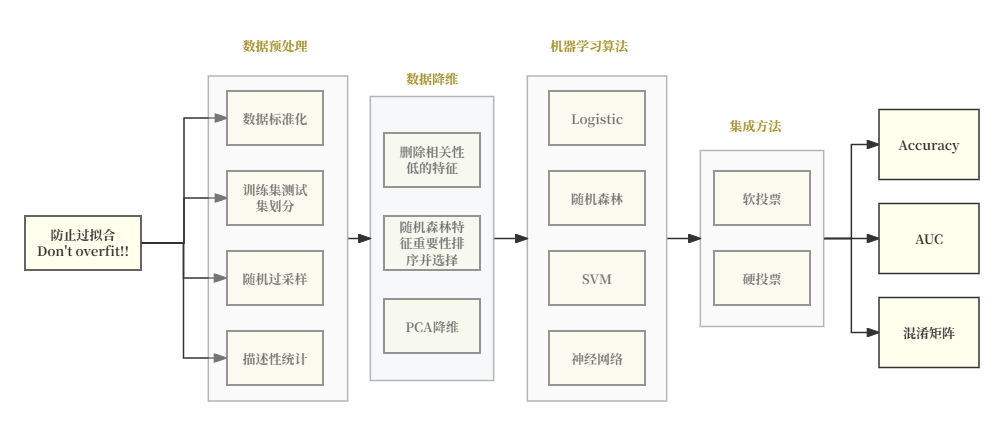

# 引言

在当今数据驱动的世界中，机器学习已经成为解决复杂问题的强大工具，从图像识别到自然语言处理，再到医学诊断和金融预测，机器学习的应用几乎无处不在。然而，随着这些技术的迅猛发展，研究人员和实践者面临的一个主要挑战便是模型的过拟合问题。过拟合是指模型在训练数据上表现良好，但在未见过的测试数据或实际应用中表现较差的现象。这种现象严重制约了模型的泛化能力，削弱了机器学习在现实世界中解决问题的效力。

过拟合的本质在于模型对训练数据的“过度学习”。当一个模型变得过于复杂，能够捕捉训练数据中的噪声和异常时，尽管其在训练集上的预测精度可能非常高，但在面对新数据时，这些“学到”的噪声和异常反而导致预测性能的大幅下降。过拟合不仅使得模型难以适应新数据，还增加了计算复杂性和资源消耗，降低了模型的实际可用性和可扩展性。

在本文中，我们处理的是一个二分类任务，面对的训练数据集存在明显的过拟合风险，主要原因在于数据集的特征数量远远超过样本数量。具体而言，我们的训练数据包含250个样本，却有多达300个特征，而我们需要用训练好的模型去预测19750个样本。这种数据特征与样本数量之间的失衡关系导致了几个主要的**过拟合原因**：

**维数灾难（Curse of Dimensionality）**：
维数灾难是指当特征维度（即特征数量）增加时，数据空间变得极为稀疏，导致模型难以泛化。由于每个特征维度的增加都会成倍地增加数据空间的体积，在特征数量多于样本数量的情况下，模型很容易在训练数据上表现得很好，但在新数据上却难以维持同样的性能。这是因为模型可能在高维空间中找到训练数据的复杂模式，但这些模式往往是特定于训练数据的噪声，而不是数据的真实分布。

**模型复杂度过高**：
当特征数量多于样本数量时，模型的参数空间也随之增大。这种情况下，模型可以通过调整大量参数来完美地拟合训练数据，包括噪声和异常值。这种高度灵活性导致模型在训练数据上表现出色，但在面对新的、未见过的数据时，却表现不佳，因为模型无法区分真正的信号和噪声。

**样本不足**：
250个样本对于300个特征，250个训练集数据对19750个测试集数据显然是不足的。通常，机器学习模型需要更多的样本来捕捉数据的多样性和分布情况。样本不足意味着模型没有足够的数据来学习每个特征的真实分布和重要性，这使得模型更倾向于记住训练数据的细节而不是理解数据的整体结构。

**噪声和异常值的影响**：
在特征数量远多于样本数量的情况下，训练数据中的噪声和异常值对模型的影响会被放大。模型可能会过度拟合这些噪声和异常值，从而进一步降低在新数据上的泛化能力。高维数据中，每个噪声或异常值都有可能被模型视为重要特征，从而影响模型的整体表现。

为了解决过拟合问题，本文提出了多种技术和策略。从数据层面出发，因为数据有严重的不平衡问题，本文使用**过采样方法**，它是通过人工合成新样本来处理样本不平衡问题，从而提升数据的多样性和模型的鲁棒性。

为了**降低特征维度**，本文进行了**特征筛选**，使用**随机森林重要性**识别重要特征，对特征个数k进行搜索，取Logistic模型最大AUC值对应的k值作为最终的特征个数；除此之外，还尝试了**主成分分析**进行特征降维。

在模型结构和训练过程方面，本文使用**正则化技术：L1和L2正则化**，在损失函数中添加惩罚项，限制模型参数的大小，从而防止过度拟合。

**交叉验证**是另一种广泛应用的防止过拟合的方法。本文通过将数据集划分为多个子集，并在不同的子集上反复训练和验证模型，交叉验证能够更准确地评估模型的性能，并帮助选择最佳的模型参数。

总之，过拟合问题是机器学习领域不可忽视的挑战，它不仅影响模型的性能，还关系到其在现实应用中的有效性和可靠性。本文通过结合特征筛选、过采样、正则化、交叉验证等多种技术，以应对这一难题。

# 方法

### 导入包（可不看）

In [15]:
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils import resample
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pandoc

## 过拟合的原因

In [2]:
# 数据集的形状
train_data = pd.read_csv(r'./train.csv')
test_data = pd.read_csv(r'./test.csv')
print(f"The shape of train data is: {train_data.shape}")
print(f"The shape of test data is: {test_data.shape}")

The shape of train data is: (250, 302)
The shape of test data is: (19750, 301)


In [3]:
train_data.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [4]:
test_data.head()

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,-0.677,1.721,-0.745,-0.838,0.149,-1.138,0.242,0.504,-1.829,...,-1.180,-0.403,0.759,-0.600,0.951,-0.349,0.446,-0.819,-0.277,1.297
1,251,-0.731,-0.251,0.059,0.054,1.149,2.462,0.836,0.719,-2.269,...,1.297,1.114,0.657,0.760,0.899,-1.612,-1.701,1.107,-0.314,-0.641
2,252,1.119,1.036,1.220,1.518,0.265,-0.088,0.245,-0.533,-0.921,...,-0.864,-0.736,0.367,0.154,0.830,-1.352,0.914,0.377,0.588,-0.912
3,253,-0.933,0.212,-0.053,0.570,-1.540,-1.108,0.462,1.022,-0.215,...,0.063,-0.958,0.762,-0.213,-2.171,0.830,1.435,0.125,2.782,0.619
4,254,-0.208,-0.556,2.641,0.853,-0.384,0.312,0.514,0.481,-1.929,...,-0.689,0.213,0.568,-0.935,-0.015,0.267,0.739,1.340,-0.178,1.010


从上面的结果我们可以看出数据存在以下问题：

+ 维数灾难：数据集的特征数量远远超过样本数量。高维数据需要更多的计算资源来处理和分析，同时高维数据中的噪声也会增多。这些噪声和无关特征可能会被模型错误地视为有用信息，从而影响模型的泛化能力。


+ 样本不足：
    250个样本对于300个特征的情况下，样本数量明显不足。样本不足还会导致模型参数过多而训练数据过少的情况。模型参数越多，模型越复杂，需要更多的数据来训练和验证参数。当训练数据不足时，模型可能会过度拟合训练数据，而无法在新数据上表现良好。
    
    在本文中，我们的训练集只有250个样本，而测试集却有19750个样本。这种不平衡进一步放大了样本不足的问题。训练集的数据量过小，无法提供足够的信息让模型学习到数据的普遍特征，从而导致模型在测试集上的表现较差。

## 补充实验

小组报告和个人报告中将会在原始代码的基础上补充下面7个实验，并进行解释与讨论（有些地方重复，个人报告就不再展示）：

+ 训练集内部划分
+ 随机过采样
+ 主成分分析PCA降维
+ 神经网络Tensorflow框架搭建
+ 训练集内部划分得到的测试集的结果（补充AUC性能指标的计算）
+ 投票结果与单个分类器结果比较
+ 提交kaggle获得准确率

### 基础代码（为了后面的新增实验展示，放入此段数据预处理代码，已简化，可不看）

In [5]:
num_cols=train_data.columns.drop(['target','id'])

#训练集数据标准化
std=StandardScaler()
train_copy=train_data.copy()
train_copy[num_cols]=std.fit_transform(train_data.drop(columns=['target','id']))

In [6]:
#测试集数据标准化
std=StandardScaler()
test_copy=test_data.copy()
test_copy[num_cols]=std.fit_transform(test_data.drop(columns=['id']))

### 补充内容1：train_copy内部划分训练集与测试集

由于原始数据测试集不含标签`target`，无法使用测试集评估我们的方法在测试集上的性能以及是否真正有效的防止过拟合，为了获得有标签的测试集，我们在原始训练集`train_copy`上使用`train_test_split()`函数划分训练集和测试集，留30%的样本做测试集`test`，70%的样本为训练集`train`。

In [7]:
train, test = train_test_split(train_copy, test_size=0.3, random_state=70, shuffle=True)

### 补充内容2：过采样
随机过采样是最简单的过采样方法，用于处理**数据不平衡**。它通过随机复制少数类样本来增加少数类的数量，直到与多数类样本数量相等。这种方法特别适用于数据较少且类别不平衡较为严重的情况。

数据不平衡的危害：

在一个医疗诊断系统中，我们要检测一种罕见疾病，患病率为1%。假设数据集中有990个健康样本和10个患病样本。由于健康样本占绝大多数，模型可能会倾向于预测“健康”，以提高总体准确性。这种情况下，模型的总体准确率可能非常高（例如99%），但对于患病样本的召回率（真正率）可能非常低，导致很多患病患者被误诊为健康。

随机过采样的主要步骤:
+ 识别少数类和多数类：首先，确定数据集中哪个类别是少数类，哪个类别是多数类
+ 随机复制少数类样本：从少数类样本中随机选择样本，并复制这些样本直到少数类样本数量与多数类样本数量相等
+ 合并数据集：将过采样后的少数类样本与多数类样本合并，形成一个新的平衡数据集

随机过采样方法简单易行，只是复制现有样本，不会引入新的数据特性；复制样本会使数据集变大，增加训练时间和存储需求。

除了随机过采样外，常见的过采样方法还有ADASYN、Borderline-SMOTE和KMeans-SMOTE等。

下面首先对训练集中的各类别样本数进行统计：

In [8]:
train['target'].value_counts()

target
0.0    127
1.0     48
Name: count, dtype: int64

从上面的结果可以看出，`target`为0的样本数量为`target`1的样本数量的2倍，数据存在较严重的不平衡问题。为了解决由于数据不平衡带来的问题，我们使用`sklearn`模组中的`resample`函数进行**随机过采样**。

In [9]:
# 分离多数类和少数类
train_majority = train[train.target == 0]
train_minority = train[train.target == 1]

# 随机过采样少数类
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # 允许放回抽样
                                 n_samples=len(train_majority),    # 过采样至与多数类样本相同数量
                                 random_state=42)  # 固定随机种子

# 合并过采样后的数据集
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# 查看过采样后的类别分布
print("过采样后的类别分布:")
print(train_upsampled['target'].value_counts())

过采样后的类别分布:
target
0.0    127
1.0    127
Name: count, dtype: int64


随机过采样后的训练集存储为`train_upsampled`，从上面的结果输出可以看出过采样后的数据中`target`为0的样本有127个，`target`为1的样本也有127个，类别平衡，但样本量增多。

### 补充内容3：主成分分析PCA降维

除了使用随机森林进行特征重要性排序之外，还有一类进行特征降维的方法被广泛使用，其中最著名的就是主成分分析（PCA）。主成分分析是一种统计技术，通过正交变换将原始数据转换为一组新的变量（称为主成分），这些新变量是原始变量的线性组合，并且尽可能多地保留了原始数据中的方差信息。在最终的小组报告中，我们绘制了碎石图，并选取了解释方差的前80%作为主成分分析的维度。我们使用`pca.fit_transform()`进行PCA降维，并利用降维后数据进行模型拟合和预测，但发现预测效果并不好，这可能是因为PCA是线性方法，无法处理数据中的非线性关系。所以我们最终提交kaggle的版本是使用随机森林特征重要性降维方法进行模型拟合的。

### 补充内容4：神经网络Tensorflow框架搭建

在之前的代码中，我使用sklearn自带的`MLPClassifier`函数建立神经网络模型，接下来我们使用Tensorflow框架复现之前的模型：

#### 基础代码（原本小组报告中的数特征降维、模型训练；可不看）

In [10]:
# 提取特征列和目标列，train_copy已经去掉'id'列
train_features = train_upsampled.drop('target', axis=1)
train_target = train_upsampled['target']

# 计算特征与目标列的相关性
train_correlation = train_features.corrwith(train_target,method='spearman')

# 去除相关性低于0.01的特征
low_corr_features = train_correlation[abs(train_correlation) < 0.01]
filtered_features = train_features.drop(low_corr_features.index, axis=1)

# 计算去除的特征数量
removed_feature_count = len(low_corr_features)

target = train_target
# 创建随机森林分类器模型
model = RandomForestClassifier(random_state=42)

# 拟合随机森林模型
model.fit(filtered_features, target)

# 获取特征重要性得分
feature_importances = model.feature_importances_

# 创建特征重要性得分的索引数组
feature_indices = np.argsort(feature_importances)[::-1]

# 根据特征重要性得分对剩余特征进行排序
sorted_features = filtered_features.columns[feature_indices]

# 创建特征重要性得分的索引数组和排序后的特征重要性得分
feature_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[feature_indices]

# 创建特征名称列表
sorted_feature_names = filtered_features.columns[feature_indices]

# 定义空列表存储特征数量和对应的 AUC
feature_counts = []
auc_scores = []

# 根据随机森林的特征重要性排序结果，选择不同数量的特征
for k in range(5, 100, 1):
    selected_features = sorted_feature_names[:k]  # 选择前 k 个特征
    X_selected = filtered_features[selected_features]

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_selected, target, test_size=0.2, random_state=42)

    # 训练 logistic 回归模型
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    # 预测测试集
    y_pred = model.predict_proba(X_test)[:, 1]

    # 计算 AUC
    auc = roc_auc_score(y_test, y_pred)

    # 存储特征数量和对应的 AUC
    feature_counts.append(k)
    auc_scores.append(auc)

# 获取最大 AUC 对应的特征数量的索引
max_auc_index = np.argmax(auc_scores)

# 输出最大 AUC 对应的特征数量
max_auc_features = feature_counts[max_auc_index]
# 获取选择特征的数据
selected_data = filtered_features[selected_features]

# 输出选择的特征及相应的数据
selected_data_max_auc_features = selected_data.iloc[:, :max_auc_features]

#特征的列名
index = selected_data.columns.tolist()[0:max_auc_features]

X = train_upsampled[index]
y = train_upsampled['target']

#Logistic回归
# 定义参数网格
param_grid = {
    'C': [0.01, 0.1],       # 正则化强度
    'penalty': ['elasticnet'], # 正则化类型
    'solver': ['saga'],  # solver 必须与正则化类型兼容，'saga' 支持所有正则化
    'l1_ratio': np.linspace(0, 1, 3)     # l1_ratio 仅在 penalty 为 'elasticnet' 时使用
}

# 初始化逻辑回归分类器
logreg_classifier = LogisticRegression(random_state=42, max_iter=10000)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=logreg_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的AUC值
auc_values = []
for c in param_grid['C']:
    for l1_ratio in param_grid['l1_ratio']:
        auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['C'] == c and grid_search.cv_results_['params'][j]['l1_ratio'] == l1_ratio])

# 使用最佳参数训练模型
best_logreg_classifier = grid_search.best_estimator_

#随机森林
# 定义参数网格
param_grid = {
    'n_estimators': [50, 100],      # 决策树的数量
    'max_depth': [None, 3, 6],       # 树的最大深度
    'min_samples_split': [2, 4],     # 内部节点再划分所需的最小样本数
    'min_samples_leaf': [1, 2]       # 叶子节点所需的最小样本数
}

# 初始化随机森林分类器
rf_classifier = RandomForestClassifier(random_state=42)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的AUC值
auc_values = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['n_estimators'] == n_estimators and grid_search.cv_results_['params'][j]['max_depth'] == max_depth and grid_search.cv_results_['params'][j]['min_samples_split'] == min_samples_split and grid_search.cv_results_['params'][j]['min_samples_leaf'] == min_samples_leaf])

# 使用最佳参数训练模型
best_rf_classifier = grid_search.best_estimator_

#SVM
# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10],              # 正则化参数
    'kernel': ['linear', 'rbf'],    # 核函数类型
    'gamma': ['scale', 'auto']      # 核系数
}

# 初始化 SVM 分类器
svm_classifier = SVC(random_state=42,probability=True)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的 AUC 值
auc_values = []
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['C'] == C and grid_search.cv_results_['params'][j]['kernel'] == kernel and grid_search.cv_results_['params'][j]['gamma'] == gamma])

# 使用最佳参数训练模型
best_svm_classifier = grid_search.best_estimator_

#神经网络
# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],   # 隐藏层神经元数量
    'activation': ['relu', 'tanh'],                    # 激活函数类型
    'solver': ['adam'],                                # 优化器类型
    'alpha': [0.0001, 0.001]                           # L2正则化参数
}

# 初始化神经网络分类器
nn_classifier = MLPClassifier(random_state=42, max_iter=1000)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(estimator=nn_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的 AUC 值
auc_values = []
for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for alpha in param_grid['alpha']:
            auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['hidden_layer_sizes'] == hidden_layer_sizes and grid_search.cv_results_['params'][j]['activation'] == activation and grid_search.cv_results_['params'][j]['alpha'] == alpha])

# 使用最佳参数训练模型
best_nn_classifier = grid_search.best_estimator_

#### Tensorflow复现sklearn神经网络
用sklearn实现神经网络只需要用MLPClassifier()即可，我们选择的最佳模型是` {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}`。下面我们使用Tensorflow框架复现该模型：

In [11]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
index = selected_data.columns.tolist()[0:max_auc_features]
X = train_upsampled[index]
y = train_upsampled['target']

# 定义模型
model = Sequential()

# 添加隐藏层
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001), input_shape=(max_auc_features,)))

# 添加输出层，二分类问题
model.add(Dense(1, activation='sigmoid'))

# 编译模型
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X, y, epochs=1000, batch_size=32, validation_split=0.2,verbose=0)

In [12]:
np.sum(np.where(model.predict(test[index]) > 0.5, 1, 0).flatten() == test['target'])/test.shape[0]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 


0.8

在Tensorflow框架中，我们自定义隐藏层，输出层，并设置epochs=1000来控制训练的最大迭代次数。使用Tensorflow创建的神经网络模型的`Accuracy`与sklearn中的神经网络模型相同。

### 补充内容5：训练集内部划分得到的测试集的结果

针对二分类机器学习任务，以下是常见评估指标的解释，在最终的小组报告中我们计算了混淆矩阵、Accuracy，下面补充AUC值的计算：

**混淆矩阵 (Confusion Matrix)**:

混淆矩阵是一个二维表格，用于展示分类模型预测结果的准确性。

其中包括四种结果：真阳性 (True Positive, TP)，真阴性 (True Negative, TN)，假阳性 (False Positive, FP)，假阴性 (False Negative, FN)。

真阳性 (True Positive, TP):真阳性是指模型将正例样本正确地预测为正例的情况。在医学检测中，例如将病人诊断为患病并且病人实际上确实患病的情况，就是一个真阳性。

真阴性 (True Negative, TN):真阴性是指模型将负例样本正确地预测为负例的情况。比如将健康人诊断为健康，并且这些人实际上确实健康，就是一个真阴性。

假阳性 (False Positive, FP):假阳性是指模型将负例样本错误地预测为正例的情况，也称为误报。例如将健康人错误地诊断为患病，即模型预测为阳性但实际上是阴性，就是一个假阳性。

假阴性 (False Negative, FN):假阴性是指模型将正例样本错误地预测为负例的情况，也称为漏报。比如将患病的人错误地诊断为健康，即模型预测为阴性但实际上是阳性，就是一个假阴性。混淆矩阵有助于计算其他评估指标，如准确率、精确率、召回率等。

小组报告中使用`confusion_matrix(真实标签, 预测标签)`得到混淆矩阵。

**AUC (Area Under the Curve)**:

AUC 是 ROC 曲线 (Receiver Operating Characteristic Curve) 下的面积。
ROC 曲线展示了在不同分类阈值下真阳性率 (TPR) 和假阳性率 (FPR) 之间的权衡。
AUC 提供了模型预测排序的一个整体性能指标，通常用于评估二分类模型的预测能力，数值越大表示模型性能越好。

本文使用`roc_auc_score(真实标签, 预测标签为1的概率)`得到AUC指标。

**Accuracy (准确率)**:

准确率衡量了模型预测正确的样本数量占总样本数量的比例。
公式为 Accuracy = (TP + TN) / (TP + TN + FP + FN)，即所有预测正确的样本占总样本数量的比例。
准确率适用于类别分布均匀的数据集，但在类别不平衡的情况下可能不是一个理想的评估指标。

小组报告中使用`预测标签与真实标签相等的样本数/总样本数`计算准确率，实际上还可以使用`accuracy_score(真实标签, 预测标签)`计算准确率。

在最终的小组报告中我们计算了混淆矩阵、Accuracy，下面补充AUC值的计算：

In [14]:
print(f'logistic_auc：{roc_auc_score(test['target'], best_logreg_classifier.predict_proba(test[index])[:,1])}')
print(f'rf_auc：{roc_auc_score(test['target'], best_rf_classifier.predict_proba(test[index])[:,1])}')
print(f'svm_auc：{roc_auc_score(test['target'], best_svm_classifier.predict_proba(test[index])[:,1])}')
print(f'nn_auc：{roc_auc_score(test['target'], best_nn_classifier.predict_proba(test[index])[:,1])}')

logistic_auc：0.7114661654135338
rf_auc：0.5888157894736842
svm_auc：0.662593984962406
nn_auc：0.6766917293233082


### 补充内容6：投票结果与单个分类器结果比较
投票法（voting）是集成学习里面针对分类问题的一种结合策略。通过多个模型的集成降低方差，从而提高模型的鲁棒性 （算法对数据变化的容忍度有多高）。在理想情况下，投票法的预测效果应当优于任何一个基模型的预测效果。

投票法分为硬投票和软投票。在硬投票中，每个算法的预测都被认为是选择具有最高票数的类的集合。在软投票中，每个类别的概率被平均以产生结果。

在小组报告中，我们对两种投票都进行了尝试，**发现软投票结果更优，且优于单个基模型的结果**。这可能是因为：

1. 软投票使用了更丰富的信息
2. 软投票通过加权平均不同模型的预测概率，能够更好地平滑各个模型的预测误差。如果某个模型对某些样本的预测不确定，其他模型可能会提供更可靠的概率，从而减小整体误差。

在最后的kaggle测试集预测中，我们使用4个模型的软投票集成模型进行预测。

### 补充内容7：提交Kaggle获得准确率
使用随机森林降维方法，使用多个机器学习模型的软投票集成对kaggle提供的测试集数据进行预测，得分为0.761。虽然我们的结果在排行榜上并不突出，但我们的方案考虑了数据不平衡问题，防止分类器简单的将所有数据预测为多数类，造成准确率很高，但其他性能指标很差的结果。

## 特征降维防止过拟合
特征降维在机器学习中是防止过拟合的重要手段之一。过拟合通常由于模型在训练过程中过度适应训练数据的特定特征和噪声，而导致在未见过的数据上表现不佳。在文章中，既使用了随机森林特征重要性排序筛选特征，也采用了主成分分析（PCA）进行降维，但发现**随机森林特征筛选的效果比PCA更为显著**。

随机森林特征重要性排序能够有效地评估每个特征对目标变量的贡献，进而筛选出对预测最为重要的特征。这种方法不仅简单直观，而且能够保留数据中的关键信息，有助于提高模型的预测能力和泛化能力。相比之下，PCA虽然能够降低数据的维度并减少冗余信息，但其线性变换可能**无法充分捕捉非线性关系**，导致在某些复杂数据集上表现不如随机森林特征筛选明显。

综上所述，结合实际问题和数据特性，正确选择和应用特征降维技术，能够有效地优化模型的复杂度和泛化能力，从而提升机器学习应用的效果和稳定性。

## 正则化防止过拟合

正则化的引入是为了防止模型过拟合，这是因为在机器学习中，过拟合通常发生在模型在训练数据上表现非常好，但在测试数据上表现较差的情况下。过拟合的主要原因是模型复杂度过高，参数过多，使得模型能够完美拟合训练数据中的噪声和异常点，从而失去对新数据的泛化能力。

通过正则化，我们在损失函数中增加了对模型参数的惩罚项，这样可以**迫使模型在训练过程中不仅要最小化误差，还要控制模型参数的大小和复杂度**。具体来说：

L1正则化（Lasso正则化）通过在损失函数中加入$||w||_1$项，可以使某些参数的权重变为零，从而达到特征选择的效果。它鼓励稀疏解，即只保留少数重要特征，避免模型过于复杂。

L2正则化（Ridge正则化）通过在损失函数中加入$||w||^2_2$项，防止参数过大。它鼓励模型参数尽量均匀分布，使得模型更加稳定，不容易被训练数据中的噪声干扰。

ElasticNet正则化结合了L1和L2正则化的优点，可以在稀疏性和参数稳定性之间取得平衡。通过调整l1_ratio，我们可以控制L1和L2正则化项的权重，从而灵活应对不同的数据情况。

总之，正则化通过对模型参数的约束，有效地防止了模型过拟合，提高了模型在新数据上的泛化能力。在实际应用中，我们可以通过交叉验证等方法选择最优的正则化参数，确保模型的性能和稳定性。

在本文中，我们建立了Logistic分类器用于`target`标签的判别，在其中我们使用[elasticnet函数](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)进行正则化，下面是它的公式：

$\frac{1}{(2 * samples)}$ * $||y - Xw||^2_2$+ $\alpha$ * l1_ratio * $||w||_1$+ 0.5 * $\alpha$ * (1 - l1_ratio) * $||w||^2_2$

从上式可以看出，ElasticNet函数其实就是综合了L1正则化项和L2正则化项，通过l1_ratio调节两个正则化项的比例，所以该参数取值在0到1之间

在小组报告的Logistic回归中，我们设置参数网格对C（正则化强度，正则化系数$\lambda$的倒数，C越小的数值表示越强的正则化）和l1_ratio进行五折交叉验证调参，并输出不同正则化参数下对应的五折交叉验证AUC值箱线图。

## 交叉验证防止过拟合

交叉验证通过将数据集分成多个子集，并多次训练和评估模型，从而获得对模型性能的更可靠估计。这样可以避免单次划分数据集带来的偏差，确保模型在不同数据分布上的稳健性。

交叉验证通过以下方法防止过拟合：

**多次验证**：交叉验证通过多次分割数据并进行训练和验证，确保评估结果不依赖于单一的数据划分。这样可以有效避免模型对特定训练集的过拟合。

**稳定性评估**：交叉验证提供了K次评估结果的方差信息，帮助我们了解模型性能的稳定性。如果模型在不同的子集上表现出较大的性能波动，说明模型可能对某些数据子集过拟合。

**参数选择**：在调参过程中，我们可以使用交叉验证评估不同参数组合的性能，选择使得平均性能最佳且波动最小的参数。这有助于找到在新数据上也能表现良好的参数组合。

在小组报告中，我们使用了五折交叉验证，不依赖于单一的数据划分，避免模型对特定数据集过拟合；通过五组不同子集上的模型性能指标的波动（箱线图的箱体长度），可以进行稳定性评估；通过将交叉验证与参数选择项结合，寻找性能指标最佳且波动最小的参数，这些参数在新数据集上也能有较好的表现。

# 结论

在本研究中，我们采用了多种方法来应对机器学习模型中常见的过拟合现象。首先，我们通过合理的训练集内部划分，确保模型在训练过程中能够充分泛化，同时利用随机过采样技术来处理类别不平衡数据，以提高模型对少数类样本的学习能力。此外，我们还应用了随机森林特征筛选、主成分分析（PCA）对数据进行了特征降维处理，从而降低模型的复杂度和过拟合的风险。在模型拟合时，我们还使用了正则化和交叉验证用于防止过拟合。

在评估阶段，我们不仅使用准确率（Accuracy）、混淆矩阵来验证模型的性能，还引入了AUC（曲线下面积）作为评估指标。同时，我们使用TensorFlow框架搭建神经网络模型复现sklearn拟合出来的神经网络。

通过这些方法和实验，我们有效地应对过拟合问题，使模型在真实数据上表现更加稳定和可靠，从而为实际应用提供更好的预测能力和思路参考。

# 讨论

## 1. 为什么会产生过拟合？

主要原因在于数据集的特征数量远远超过样本数量。具体而言，我们的训练数据包含250个样本，却有多达300个特征，而我们需要用训练好的模型去预测19750个样本。这种数据特征与样本数量之间的失衡关系导致了过拟合。

## 2. 为什么要进行随机过采样？

随机过采样是最简单的过采样方法，用于处理**数据不平衡**。它通过随机复制少数类样本来增加少数类的数量，直到与多数类样本数量相等。这种方法特别适用于数据较少且类别不平衡较为严重的情况。

数据不平衡的危害：在一个医疗诊断系统中，我们要检测一种罕见疾病，患病率为1%。假设数据集中有990个健康样本和10个患病样本。由于健康样本占绝大多数，模型可能会倾向于预测“健康”，以提高总体准确性。这种情况下，模型的总体准确率可能非常高（例如99%），但对于患病样本的召回率（真正率）可能非常低，导致很多患病患者被误诊为健康。

## 3. 为什么随机森林特征筛选比主成分分析效果好？

随机森林特征重要性排序能够有效地评估每个特征对目标变量的贡献，进而筛选出对预测最为重要的特征。这种方法不仅简单直观，而且能够保留数据中的关键信息，有助于提高模型的预测能力和泛化能力。相比之下，PCA虽然能够降低数据的维度并减少冗余信息，但其线性变换可能**无法充分捕捉非线性关系**，导致在某些复杂数据集上表现不如随机森林特征筛选明显。

## 4. TensorFlow搭建神经网络与使用sklearn建立神经网络模型有什么异同？

TensorFlow和scikit-learn在搭建神经网络模型方面有显著的异同。TensorFlow 是一个专门用于构建和训练深度学习模型的框架，它提供了**底层的操作和灵活性**，允许用户定义复杂的神经网络架构，并优化模型的各个方面。TensorFlow支持多种高级API，如Keras，使得定义、训练和调试神经网络变得更加简单和直观。这使得TensorFlow特别适合于需要处理**大规模数据和复杂模型的深度学习应用**，例如图像识别、自然语言处理和推荐系统。

scikit-learn 则是一个通用的机器学习库，包括**传统的机器学习算法和工具**，如决策树、支持向量机和随机森林等。尽管scikit-learn也提供了一些简单的神经网络模型，例如多层感知器（MLP），但其主要设计目的是支持传统的机器学习任务。相比TensorFlow，scikit-learn在神经网络方面的功能和灵活性较为有限，适合于**简单的神经网络结构和小规模数据集**的应用。

## 5. 为什么不能只看Accuracy指标，还要参考混淆矩阵与AUC值？

在二分类任务中，评估模型性能不能仅依赖于Accuracy指标，而需要综合考虑混淆矩阵和AUC值。Accuracy指标虽然直观，但在面对**类别不平衡**的数据集时可能会产生**误导性的高分**，因为它只是简单地计算了模型预测正确的样本比例。而混淆矩阵则提供了更详细的分类结果，包括True Positive (TP)、True Negative (TN)、False Positive (FP)和False Negative (FN)，这些指标能够帮助我们理解模型在每个类别上的表现和误判情况。

另一方面，AUC值衡量了模型将正例排在负例前面的能力，是一个**综合考量模型分类性能的重要指标**。它不受类别分布不均衡的影响，因此更能客观地评估模型的预测能力和区分能力。通过结合混淆矩阵和AUC值，我们可以更全面地了解模型的准确性、召回率和误判率，帮助我们做出更准确的模型选择和优化决策，以满足不同业务场景的需求。综上所述，综合使用这些指标能够更有效地评估和优化二分类模型，提升其在实际应用中的有效性和稳健性。

## 6. 软投票预测效果为什么好于硬投票？

软投票使用了**更丰富的信息**；软投票通过加权平均不同模型的预测概率，能够更好地**平滑**各个模型的预测误差。如果某个模型对某些样本的预测不确定，其他模型可能会提供更可靠的概率，从而减小整体误差。

## 7. 为什么需要在训练集内部拆分出测试集？

由于kaggle提供的测试集不含标签，为了更全面地检验模型性能，我们**需要一个含有标签的测试集**，所以我们对训练集按照0.7/0.3的比例进行拆分，得到样本量为75的测试集。

## 8. 为什么使用集成方法？

由于我们使用了多个不同的模型，为了综合不同模型的优势，获得更稳健的模型，得到最终的预测结果，我们考虑了集成方法。

# 感想与致谢

本文主要处理了一个二分类任务，面对的训练数据集由于特征数量远超样本数量，存在明显的过拟合风险。这种情况下，我们的模型在训练集上可能表现优异，但在面对新数据时却无法保持同样的预测能力，这严重制约了模型的泛化能力和实际应用效果。

通过深入分析，我们发现过拟合的主要原因包括维数灾难、模型复杂度过高、样本不足以及噪声和异常值的影响。维数灾难使得高维空间中模型难以泛化，而模型复杂度过高则导致模型过度拟合训练数据中的噪声和异常值。此外，由于样本数量不足，模型无法充分学习数据的整体结构，从而进一步降低了其在新数据上的表现。

为了有效应对这些挑战，本文提出了一系列解决方案。我们采用了过采样方法提升模型的鲁棒性。在特征选择方面，我们使用了随机森林重要性和主成分分析（PCA）等方法，有效降低了数据的维度，并提升了模型的泛化能力。此外，我们还引入了正则化技术和交叉验证，限制模型的复杂度，提高了模型在新数据上的预测准确性。

特此感谢《应用线性模型》课程的老师在课堂上耐心解答我们的问题，并提供了丰富的实例和案例，帮助我们深入理解和应用线性回归模型，使得我们能够共同探索解决实际问题的方法。

通过本课程的学习和实践，我们不仅深入理解了线性回归模型的原理和应用，还学会了如何面对数据中的挑战并提出有效的解决方案。这些知识和技能将对我们未来在机器学习、数据科学、统计学领域的研究和实践产生深远影响。

# 参考文献

[1] 机器学习及其应用[M]. 清华大学出版社有限公司, 2006.

[2] [scikit-learn](https://scikit-learn.org/stable/)

[3] [集成学习 模型融合方法 投票法Voting 硬投票与软投票的区别](https://blog.csdn.net/m0_73972962/article/details/131290161)

[4] [什么是过拟合？](https://www.ibm.com/cn-zh/topics/overfitting)